# Notebook to plot snowlines and respective images and select the annual ELA (maximum elevation snowline)

In [ ]:
# Install packages not already in environment
!pip install geopandas rioxarray geedim

In [ ]:
# Import packages
import os
import matplotlib.pyplot as plt
import glob
import pandas as pd
import geopandas as gpd
import numpy as np
import sys
from shapely import wkt
import sys
import json
import sys
import ee
import datetime
import ast

In [ ]:
# Authenticate your Google Earth Engine account
try:
    ee.Initialize()
except:
    ee.Authenticate()
    ee.Initialize()

In [ ]:
# If using Google Colab, mount Google Drive so you can access the files in this folder
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [ ]:
# Uncomment the line below to locate any needed paths in directory
# os.listdir('drive/MyDrive/Research/PhD/snow_cover_mapping/snow_cover_mapping_application/study-sites/')

In [ ]:
##### MODIFY HERE #####
# specify site name
site_name = 'LemonCreek'
# path to snow-cover-mapping-application/
# RAINEY'S PATH:
#base_path = 'drive/My Drive/Research/CryoGARS-Glaciology/Advising/student-research/Alexandra-Friel/snow_cover_mapping_application/snow-cover-mapping-application/'
# ALEXANDRA'S PATH:
base_path = ('drive/MyDrive/snow_cover_mapping_application/snow-cover-mapping-application/')
# path to study site
study_site_path = os.path.join(base_path, '../study-sites', site_name)
# path where figures will be saved
figures_out_path = study_site_path + 'figures/'
# path where manual ELA estimates will be saved
out_path = study_site_path +'imagery/ELAs/'
# define month range for filtering snowlines from file (includes both months)
month_start = 7
month_end = 10
#######################

# -----Determine other folders
# path to PlanetScope image mosaics
PS_im_path = os.path.join(study_site_path, 'imagery', 'PlanetScope', 'mosaics')
# path to snowline files
sl_est_path = os.path.join(study_site_path, 'imagery', 'snowlines')

# -----Load dataset characteristics
dataset_dict_fn = os.path.join(base_path, 'inputs-outputs', 'datasets_characteristics.json')
dataset_dict = json.load(open(dataset_dict_fn))

# -----Load functions from file
sys.path.append(base_path + 'functions/')
import manually_select_ELAs_utils as f



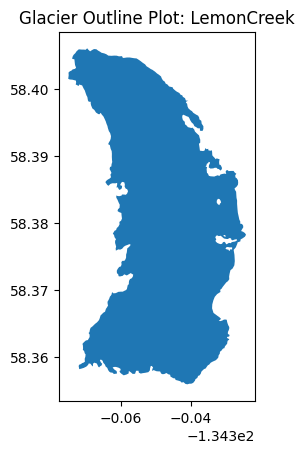

In [ ]:
# -----Load and plot glacier outline shapefile to see if the geometry is wacky!
# Eventually want to choose 10 random wacky sites and 10 random "nice" sites.

RGI_outline = os.path.join(study_site_path, 'AOIs', '*.shp') # file name
shapefiles = glob.glob(RGI_outline) # check if file name in directory

if not shapefiles:
    print(f"No shapefiles found in {RGI_outline}")
else:
    AOI_fn = shapefiles[0]
    AOI = gpd.read_file(AOI_fn)
    AOI.plot()
    plt.title('Glacier Outline Plot: ' + site_name)
    plt.show()

In [ ]:
# -----Load and compile snowline files
# Define year for selecting the ELA
year = '2022'

# grab snowline file names
sl_est_fns = glob.glob(os.path.join(sl_est_path, '*snowline.csv'))
# only include snowlines starting in 2016 (time series too sparse before then)
sl_est_fns = [sl_est_fn for sl_est_fn in sl_est_fns if year in sl_est_fn]

# compile all snowline files into one DataFrame
sl_est_full = gpd.GeoDataFrame()
for fn in sl_est_fns:
    # read file
    sl_est_df = pd.read_csv(fn)
    # create a geopandas GeoDataFrame from the DataFrame
    sl_est_df.loc[sl_est_df['geometry']=='[]', 'geometry'] = None
    sl_est_df['geometry'] = sl_est_df['geometry'].apply(wkt.loads)
    sl_est_gdf = gpd.GeoDataFrame(sl_est_df, crs='EPSG:4326',
                                  geometry=sl_est_df['geometry'])
    # concatenate to df
    sl_est_full = pd.concat([sl_est_full, sl_est_gdf])
# don't include PlanetScope
sl_est_full = sl_est_full.loc[sl_est_full['dataset'] != 'PlanetScope']
# read dates as datettime64, only include snowlines for July - November
sl_est_full['datetime'] = sl_est_full['datetime'].astype('datetime64[ns]')
sl_est_full['month'] = sl_est_full['datetime'].values.astype('datetime64[M]').astype(int) % 12 + 1
sl_est_full = sl_est_full.loc[(sl_est_full['month'] >= month_start) & (sl_est_full['month'] <= month_end)]
# remove month column
sl_est_full = sl_est_full.drop('month', axis=1)
# remove Unnamed column if present
if 'Unnamed: 0' in list(sl_est_full.columns):
    sl_est_full = sl_est_full.drop('Unnamed: 0', axis=1)
# renumber, sort by date
sl_est_full = sl_est_full.sort_values(by=['datetime']).reset_index(drop=True)

# -----Reproject AOI and snowlines to WGS84
AOI_UTM = AOI.to_crs(sl_est_full['HorizontalCRS'][0])

sl_est_full

/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,site_name,datetime,dataset,snowlines_coords_X,snowlines_coords_Y,snowline_elevs_m,snowline_elevs_median_m,SCA_m2,AAR,ELA_from_AAR_m,HorizontalCRS,VerticalCRS,geometry
0,LemonCreek,2022-07-01 14:00:19,Landsat,[],[],669.0,669.00,8289900.0,0.964907,800.413139,EPSG:32608,EPSG:5773,None
1,LemonCreek,2022-07-02 14:18:52,Sentinel-2_SR,[],[],669.0,669.00,9265400.0,0.978633,775.542969,EPSG:32608,EPSG:5773,None
2,LemonCreek,2022-07-02 14:18:52,Sentinel-2_TOA,[],[],669.0,669.00,9039700.0,0.953786,811.187147,EPSG:32608,EPSG:5773,None
3,LemonCreek,2022-07-05 14:28:49,Sentinel-2_SR,"[536725.0, 536735.0, 536740.0, 536740.0, 53674...","[6473660.0, 6473660.0, 6473665.0, 6473675.0, 6...",[717.48 721.48 725.48 724.48 724.48 723.48 724...,780.48,8871900.0,0.953609,807.800000,EPSG:32608,EPSG:5773,"LINESTRING (-134.37163 58.40219, -134.37145 58..."
4,LemonCreek,2022-07-05 14:28:49,Sentinel-2_TOA,"[538095.0, 538085.0, 538080.0, 538075.0, 53806...","[6473390.0, 6473390.0, 6473395.0, 6473400.0, 6...",[840.48 841.48 841.48 839.48 840.48 841.48 841...,800.98,8879700.0,0.953617,807.800000,EPSG:32608,EPSG:5773,"LINESTRING (-134.34823 58.39965, -134.34840 58..."
5,LemonCreek,2022-07-27 14:18:57,Sentinel-2_SR,"[537335.0, 537340.0, 537340.0, 537340.0, 53734...","[6473100.0, 6473105.0, 6473115.0, 6473125.0, 6...",[834.48 835.48 835.48 835.48 835.48 836.48 837...,876.48,5710700.0,0.834788,939.190000,EPSG:32608,EPSG:5773,"LINESTRING (-134.36128 58.39711, -134.36119 58..."
6,LemonCreek,2022-07-27 14:18:57,Sentinel-2_TOA,"[537330.0, 537330.0, 537335.0, 537340.0, 53734...","[6473105.0, 6473115.0, 6473120.0, 6473125.0, 6...",[834.48 834.48 834.48 835.48 835.48 834.48 834...,867.48,5260200.0,0.778113,993.790000,EPSG:32608,EPSG:5773,"LINESTRING (-134.36136 58.39715, -134.36136 58..."
7,LemonCreek,2022-08-04 14:28:49,Sentinel-2_SR,"[538775.0, 538765.0, 538755.0, 538750.0, 53874...","[6470100.0, 6470100.0, 6470100.0, 6470105.0, 6...",[1152.49 1150.49 1148.49 1148.49 1145.49 1145....,1144.49,4697100.0,0.918353,839.970000,EPSG:32608,EPSG:5773,"LINESTRING (-134.33715 58.37004, -134.33732 58..."
8,LemonCreek,2022-08-04 14:28:49,Sentinel-2_TOA,"[537225.0, 537220.0, 537215.0, 537210.0, 53721...","[6468840.0, 6468845.0, 6468850.0, 6468855.0, 6...",[1150.49 1150.49 1151.49 1151.49 1149.49 1145....,1145.49,4923100.0,0.962539,800.890000,EPSG:32608,EPSG:5773,"LINESTRING (-134.36385 58.35886, -134.36394 58..."
9,LemonCreek,2022-08-21 14:18:48,Sentinel-2_SR,"[537695.0, 537685.0, 537680.0, 537675.0, 53766...","[6472220.0, 6472220.0, 6472225.0, 6472230.0, 6...",[992.48 992.48 992.48 991.48 990.48 990.48 990...,945.48,7494100.0,0.784107,990.990000,EPSG:32608,EPSG:5773,"LINESTRING (-134.35527 58.38917, -134.35544 58..."


Scroll through each plot and check the box below each image to select the ELA for each year.
When finished, proceed to next cell.
 
 
Landsat 2022-07-01 14:00:19
No snowline coordinates detected


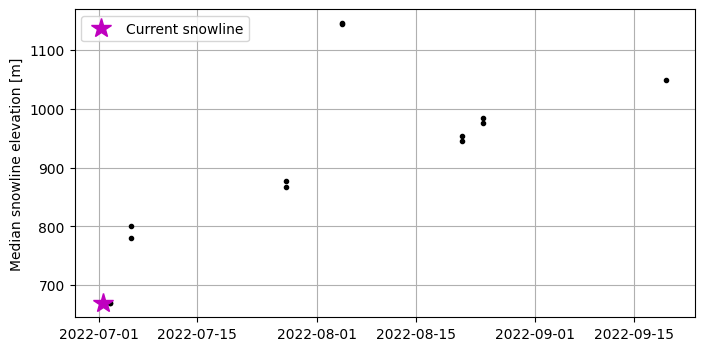

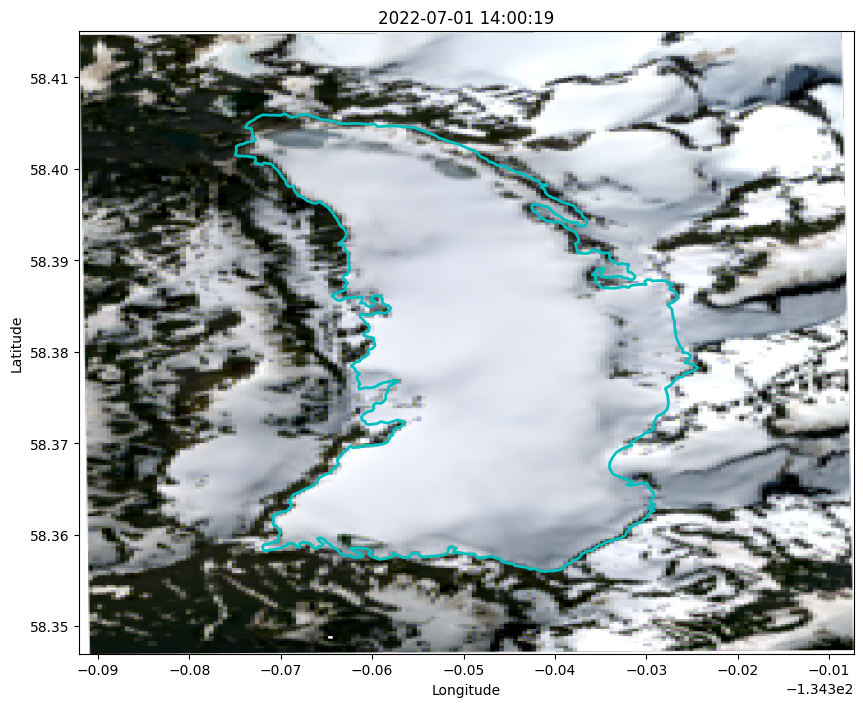

In [ ]:
checkboxes = f.manual_snowline_filter_plot(sl_est_full, dataset_dict, AOI_UTM, PS_im_path)

## 2. View resulting annual ELAs

Text(0, 0.5, 'Median snowline elevation [m]')

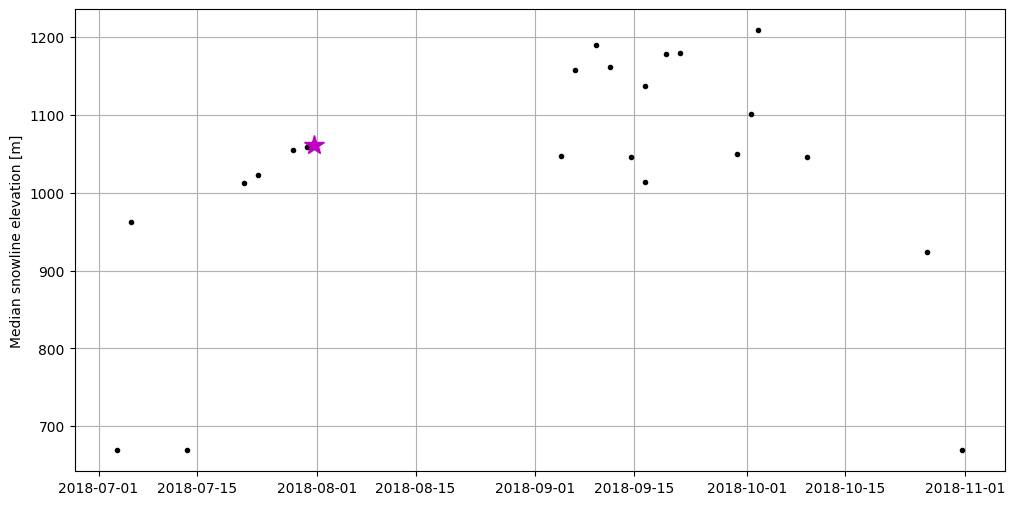

In [ ]:
# -----Grab ELA selections from checkboxes
values = np.array([x.value for x in checkboxes])
IELAs = np.ravel(np.argwhere(values==True))
ELAs = sl_est_full.iloc[IELAs]

# -----Plot
plt.figure(figsize=(12,6))
plt.plot(sl_est_full['datetime'].astype('datetime64[ns]'), sl_est_full['snowline_elevs_median_m'], '.k')
plt.plot(ELAs['datetime'].astype('datetime64[ns]'), ELAs['snowline_elevs_median_m'], '*m', markersize=15)
plt.grid()
plt.ylabel('Median snowline elevation [m]')

## 3. Save annual ELAs to file

When you're satisfied with your ELA selections, save them!

In [ ]:
# define file name and where to save it
out_fn = site_name + '_manually_selected_ELAs_' + year + '.csv'
out_path = study_site_path + 'ELAs/'

# make output directory (out_path) if it doesn't exist
if not os.path.exists(out_path):
  os.mkdir(out_path)
  print('Made directory for outputs: '+out_path)

# save to file
ELAs.to_csv(out_path + out_fn, index=False)
print('ELAs saved to file: ' + out_path + out_fn)

ELAs saved to file: drive/MyDrive/snow_cover_mapping_application/snow-cover-mapping-application/../study-sites/LemonCreekELAs/LemonCreek_manually_selected_ELAs_2018.csv


## Optional. Combine CSVs into one

In [ ]:
# Grab all the CSVs in your out path
fns = sorted(glob.glob(out_path + '*.csv'))
year_start = fns[0][-8:-4]
year_end = fns[-1][-8:-4]

# Create a new Data Frame
ELAs = pd.DataFrame()

# Loop through the CSVs
for fn in fns:
    ELA = pd.read_csv(fn)
    ELAs = pd.concat([ELAs, ELA])

# Save to file
out_fn = (out_path + 'RGI60-01.11788' + '_manually_selected_ELAs_'
            + year_start + '_' + year_end + '.csv')
ELAs.to_csv(out_fn, index=False)
print('Compiled ELAs saved to file: ' + out_fn)

In [ ]:
# Delete individual files - CHECK THE NEW FILE BEFORE DELETING THE OLD ONES
for fn in fns:
    os.remove(fn)
    print(fn + ' deleted from file.')